**<font color='blue'>The LendingClub is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, I will build a classification model to predict whether or not a loan provided by LendingClub is likely to default.**</font>

In [2]:
import pandas as pd
import numpy as np

## Load the Lending Club dataset

In [3]:
loans = pd.read_csv('./lending-club-data.csv')
loans.head(2)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.3932,20161201T000000,1,1,1


In [4]:
loans.shape, loans.columns

((122607, 68),
 Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
        u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
        u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
        u'is_inc_v', u'issue_d', u'loan_status', u'pymnt_plan', u'url', u'desc',
        u'purpose', u'title', u'zip_code', u'addr_state', u'dti',
        u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
        u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
        u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
        u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
        u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
        u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
        u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
        u'last_credit_pull_d', u'collections_12_mths_ex_med',
        u'mths_since_last_major_derog', u'policy_code', u'not_compliant'

In [5]:
#loans[['bad_loans', 'id']].groupby(['bad_loans']).aggregate('count')
loans['bad_loans'].value_counts()

0    99457
1    23150
Name: bad_loans, dtype: int64

Lets convert bad_loans column to 1 and -1 instead of 0 and 1

In [6]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: 1 if x==0 else -1)
loans['safe_loans'].value_counts(), loans['safe_loans'].value_counts(1)

( 1    99457
 -1    23150
 Name: safe_loans, dtype: int64,  1    0.811185
 -1    0.188815
 Name: safe_loans, dtype: float64)

~81% of the loans are safe and the rest are bad.

## Features for the classification algorithm

Lets use a smaller subset of features below.

In [7]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [8]:
loans.head(2)

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.0,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1


In [9]:
loans.shape

(122607, 13)

### One-hot encoding

In [10]:
loans = pd.get_dummies(loans)
loans.head(2)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
loans.shape

(122607, 68)

## Split into train and validation sets

In [12]:
train_idx = pd.read_json('./module-5-assignment-1-train-idx.json')
validation_idx = pd.read_json('./module-5-assignment-1-validation-idx.json')
train_idx.shape, validation_idx.shape

((37224, 1), (9284, 1))

In [13]:
train_data = loans.iloc[train_idx[0]]
validation_data = loans.iloc[validation_idx[0]]

In [14]:
train_data.shape, validation_data.shape, loans.shape

((37224, 68), (9284, 68), (122607, 68))

Note. Some elements in loans are included neither in train_data nor validation_data. This is to perform sampling to achieve class balance. Below shows they are much more balanced now.

In [15]:
train_data['safe_loans'].value_counts(1), validation_data['safe_loans'].value_counts(1)

( 1    0.503654
 -1    0.496346
 Name: safe_loans, dtype: float64, -1    0.503447
  1    0.496553
 Name: safe_loans, dtype: float64)

## Build a decision tree classifier

In [16]:
import sklearn
from sklearn import tree
decision_tree_model = sklearn.tree.DecisionTreeClassifier(max_depth=6)
small_model = sklearn.tree.DecisionTreeClassifier(max_depth=2)

In [17]:
decision_tree_model = decision_tree_model.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
decision_tree_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [18]:
small_model = small_model.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

In [19]:
small_model.score(train_data.drop('safe_loans', axis=1),train_data['safe_loans'])

0.61350204169353106

In [20]:
decision_tree_model.score(train_data.drop('safe_loans', axis=1),train_data['safe_loans'])

0.64052761659144641

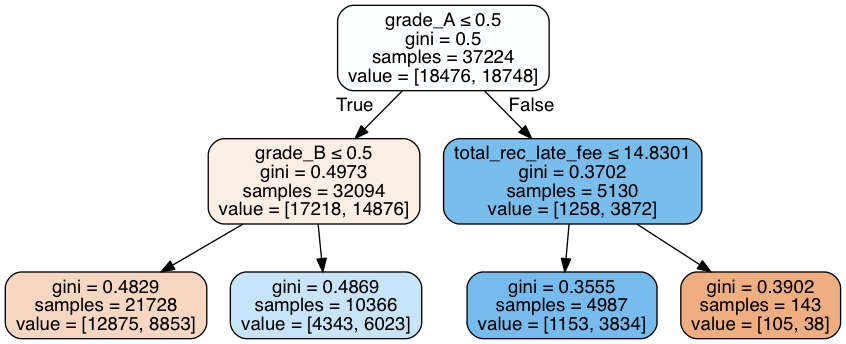

In [21]:
import pydotplus 
from IPython.display import Image
from sklearn.externals.six import StringIO

dot_data = tree.export_graphviz(small_model, feature_names=train_data.drop('safe_loans', axis=1).columns,
                               filled=True, rounded=True,special_characters=True) 
#graph = pydotplus.graph_from_dot_data(dot_data) 
#graph.write_pdf("iris.pdf") 
graph = pydotplus.graphviz.graph_from_dot_file("./tree.dot")
Image(graph.create_png()) 

In [22]:
train_data.drop('safe_loans', axis=1).head(1)
#train_data['grade_B'].value_counts()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,grade_A,grade_B,grade_C,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
1,1,1,1.0,1,1,9.4,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Making predictions

Let's consider two positive and two negative examples from the validation set and see what the model predicts. We will do the following:

Predict whether or not a loan is safe.
Predict the probability that a loan is safe.

In [23]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

In [24]:
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
prediction = decision_tree_model.predict(sample_validation_data.drop('safe_loans', axis=1))
prediction, sample_validation_data['safe_loans']

(array([ 1, -1, -1,  1]), 19    1
 79    1
 24   -1
 41   -1
 Name: safe_loans, dtype: int64)

In [26]:
import sklearn.metrics
sklearn.metrics.accuracy_score(sample_validation_data['safe_loans'], prediction)

0.5

In [27]:
decision_tree_model.predict_proba(sample_validation_data.drop('safe_loans', axis=1)) #shows prob of -1 and 1

array([[ 0.34156543,  0.65843457],
       [ 0.53630646,  0.46369354],
       [ 0.64750958,  0.35249042],
       [ 0.20789474,  0.79210526]])

In [28]:
prediction = small_model.predict(sample_validation_data.drop('safe_loans', axis=1))
prediction, sample_validation_data['safe_loans']

(array([ 1, -1, -1,  1]), 19    1
 79    1
 24   -1
 41   -1
 Name: safe_loans, dtype: int64)

In [29]:
import sklearn.metrics
sklearn.metrics.accuracy_score(sample_validation_data['safe_loans'], prediction)

0.5

In [30]:
small_model.predict_proba(sample_validation_data.drop('safe_loans', axis=1)) #shows prob of -1 and 1

array([[ 0.41896585,  0.58103415],
       [ 0.59255339,  0.40744661],
       [ 0.59255339,  0.40744661],
       [ 0.23120112,  0.76879888]])

Notice that the probability predictions are the exact same for the 2nd and 3rd loans

In [31]:
decision_tree_predictions = decision_tree_model.predict(validation_data.drop('safe_loans', axis=1))
small_tree_predictions = small_model.predict(validation_data.drop('safe_loans', axis=1))

In [32]:
import sklearn.metrics
sklearn.metrics.accuracy_score(validation_data['safe_loans'], decision_tree_predictions)

0.63614821197759586

In [34]:
import sklearn.metrics
sklearn.metrics.accuracy_score(validation_data['safe_loans'], small_tree_predictions)

0.61934510986643687